In [4]:
import time
from datetime import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
tqdm.pandas()


def timestamp(df):
    # year, month
    df["year"] = df["Timestamp"].apply(lambda x: x.year)
    df["month"] = df["Timestamp"].apply(lambda x: x.month)
    df["year"] = df["year"].astype("category")
    df["month"] = df["month"].astype("category")
    return df


def assessmentItemID(df):
    df["assessmentItemID"] = df["assessmentItemID"].astype("category")
    df["question_num"] = df["assessmentItemID"].apply(lambda x: int(x[-2:]))
#     df["question_num"] = df["question_num"].astype("category")
    df["question_class"] = df["assessmentItemID"].apply(lambda x: x[2])
    
    return df


def KnowledgeTag_relative(df):
    # KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
    df_KnowledgeTag = df.sort_values(by=["KnowledgeTag", "Timestamp"])
    df["KnowledgeTag_total_answer"] = df_KnowledgeTag.groupby("KnowledgeTag")["answercode"].cumcount()
    df["KnowledgeTag_correct_answer"] = df_KnowledgeTag.groupby("KnowledgeTag")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["KnowledgeTag_acc"] = (df["KnowledgeTag_correct_answer"] / df["KnowledgeTag_total_answer"]).fillna(0)
    return df


def userID_KnowledgeTag_relative(df):
    # userID, KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
    df_userID_KnowledgeTag = df.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)
    df["userID_KnowledgeTag_total_answer"] = df_userID_KnowledgeTag.groupby("KnowledgeTag")["answercode"].cumcount()
    df["userID_KnowledgeTag_correct_answer"] = df_userID_KnowledgeTag.groupby("KnowledgeTag")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["userID_KnowledgeTag_acc"] = (df["userID_KnowledgeTag_correct_answer"] / df["userID_KnowledgeTag_total_answer"]).fillna(0)
    return df


def assessmentItemID_relative(df):
    # assessmentItemID별 누적 풀이 수, 정답 수, 정답률
    df_assessmentItemID = df.sort_values(by=["assessmentItemID", "Timestamp"])
    df["assessmentItemID_total_answer"] = df_assessmentItemID.groupby("assessmentItemID")["answercode"].cumcount()
    df["assessmentItemID_correct_answer"] = df_assessmentItemID.groupby("assessmentItemID")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["assessmentItemID_acc"] = (df["assessmentItemID_correct_answer"] / df["assessmentItemID_total_answer"]).fillna(0)
    return df


def question_class_relative(df):
    if "question_class" not in df.columns:
        df = question_class(df)
    # Question Class 별 누적 풀이 수, 정답 수, 정답률
    df.sort_values(by=["question_class", "Timestamp"], inplace=True)
    df["question_class_correct_answer"] = df.groupby("question_class")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["question_class_total_answer"] = df.groupby("question_class")["answercode"].cumcount()
    df["question_class_acc"] = (df["question_class_correct_answer"] / df["question_class_total_answer"]).fillna(0)
    return df


def userID_question_class_relative(df):
    # question_class 있어야 계산 가능
    if "question_class" not in df.columns:
        df = question_class(df)
    # userID_question_class 키값 생성(temp)
    df["userID_question_class"] = df[["userID", "question_class"]].apply(lambda data: str(data["userID"]) + "_" + data["question_class"], axis=1)
    # userID_question_class별 시간 순으로 정렬
    df.sort_values(by=["userID_question_class", "Timestamp"], inplace=True)
    # userID_question_class별 누적 풀이 수, 정답 수, 정답률
    df["userID_question_class_correct_answer"] = df.groupby("userID_question_class")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["userID_question_class_total_answer"] = df.groupby("userID_question_class")["answercode"].cumcount()
    df["userID_question_class_acc"] = (df["userID_question_class_correct_answer"] / df["userID_question_class_total_answer"]).fillna(0)
    # userID_question_class 키값 삭제(temp)
    df.drop("userID_question_class", axis=1, inplace=True)
    return df


def question_num_relative(df):
    if "question_num" not in df.columns:
        df = question_class(df)
    # Question Class 별 누적 풀이 수, 정답 수, 정답률
    df.sort_values(by=["question_num", "Timestamp"], inplace=True)
    df["question_num_correct_answer"] = df.groupby("question_num")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["question_num_total_answer"] = df.groupby("question_num")["answercode"].cumcount()
    df["question_num_acc"] = (df["question_num_correct_answer"] / df["question_num_total_answer"]).fillna(0)
    return df


def userID_question_num_relative(df):
    # question_class 있어야 계산 가능
    if "question_num" not in df.columns:
        df = question_class(df)
    # userID_question_class 키값 생성(temp)
    df["userID_question_num"] = df[["userID", "question_num"]].apply(lambda data: str(data["userID"]) + "_" + str(data["question_num"]), axis=1)
    # userID_question_class별 시간 순으로 정렬
    df.sort_values(by=["userID_question_num", "Timestamp"], inplace=True)
    # userID_question_class별 누적 풀이 수, 정답 수, 정답률
    df["userID_question_num_correct_answer"] = df.groupby("userID_question_num")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["userID_question_num_total_answer"] = df.groupby("userID_question_num")["answercode"].cumcount()
    df["userID_question_num_acc"] = (df["userID_question_num_correct_answer"] / df["userID_question_num_total_answer"]).fillna(0)
    # userID_question_class 키값 삭제(temp)
    df.drop("userID_question_num", axis=1, inplace=True)
    return df


def userID_relative(df):
    # userID별 시간 순으로 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)
    # user 별 누적 풀이 수, 정답 수, 정답률
    df["userID_correct_answer"] = df.groupby("userID")["answercode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["userID_total_answer"] = df.groupby("userID")["answercode"].cumcount()
    df["userID_acc"] = (df["userID_correct_answer"] / df["userID_total_answer"]).fillna(0)
    return df


def userID_acc_rolling(df, window=5):
    # user_acc 있어야 이동평균 계산 가능
    if "userID_acc" not in df.columns:
        df = userID_relative(df)
    # userID별 시간 순으로 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)
    
    # userID별 정답률(user_acc)의 이동 평균
    df["userID_acc_rolling"] = df.groupby(["userID"])["userID_acc"].rolling(window).mean().values
    # userID별 window-1만큼 N/A data가 생김(rolling의 특성상 앞데이터에 생김)
    # userID별 user_acc_rolling의 중앙값으로 대체
    def changed_user_acc_rolling(data):
        return data["userID_acc_rolling_x"] if data["userID_acc_rolling_x"] != "missing" else data["userID_acc_rolling_y"]
    user_median = df.groupby("userID")["userID_acc_rolling"].median()
    df = pd.merge(df, user_median, on=["userID"], how="left")
    # 결측치 중앙값 변환 및 임시 열 삭제
    df["userID_acc_rolling_x"] = df["userID_acc_rolling_x"].fillna("missing")
    df["userID_acc_rolling_" + str(window)] = df.progress_apply(changed_user_acc_rolling, axis=1)
    df.drop("userID_acc_rolling_x", axis=1, inplace=True)
    df.drop("userID_acc_rolling_y", axis=1, inplace=True)
    
    return df


def feature_dimension_reduction(df, kind="lda"):
    if "assessmentItemID_total_answer" not in df.columns:
        df = assessmentItemID_relative(df)
    if "KnowledgeTag_total_answer" not in df.columns:
        df = KnowledgeTag_relative(df)
    if "question_class_correct_answer" not in df.columns:
        df = question_class_relative(df)
    if "userID_question_class_correct_answer" not in df.columns:
        df = userID_question_class_relative(df)
    
    if kind == "lda":
        model = LDA(n_components=1)
    elif kind == "pca":
        model = PCA(n_components=1)
    elif kind == "kpca":
        model = KernelPCA(n_components=1)
    elif kind == "kpca_rbf":
        model = KernelPCA(n_components=1, kernel="rbf")
    elif kind == "kpca_poly":
        model = KernelPCA(n_components=1, kernel="poly")
    elif kind == "svd":
        model = TruncatedSVD(n_components=1)
    else:
        return df
        
    y = df["answercode"]
    
    # KnowledgeTag_dimension_reduction
    X = df[["KnowledgeTag_total_answer", "KnowledgeTag_correct_answer", "KnowledgeTag_acc"]].fillna(0)
    df["KnowledgeTag_" + kind] = model.fit_transform(X, y)
    # userID_KnowledgeTag_dimension_reduction
    X = df[["userID_KnowledgeTag_total_answer", "userID_KnowledgeTag_correct_answer","userID_KnowledgeTag_acc"]].fillna(0)
    df["userID_KnowledgeTag_" + kind] = model.fit_transform(X, y)
    # assessmentItemID_dimension_reduction
    X = df[["assessmentItemID_total_answer", "assessmentItemID_correct_answer","assessmentItemID_acc"]].fillna(0)
    df["assessmentItemID_" + kind] = model.fit_transform(X, y)
    # question_class_dimension_reduction
    X = df[["question_class_correct_answer", "question_class_total_answer","question_class_acc"]].fillna(0)
    df["question_class_" + kind] = model.fit_transform(X, y)
    # user_question_class_dimension_reductio
    X = df[["userID_question_class_correct_answer", "userID_question_class_total_answer","userID_question_class_acc"]].fillna(0)
    df["userID_question_class_" + kind] = model.fit_transform(X, y)
    # question_num_dimension_reduction
    X = df[["question_num_correct_answer", "question_num_total_answer","question_num_acc"]].fillna(0)
    df["question_num_" + kind] = model.fit_transform(X, y)
    # user_question_num_dimension_reduction
    X = df[["userID_question_num_correct_answer", "userID_question_num_total_answer","userID_question_num_acc"]].fillna(0)
    df["userID_question_num_" + kind] = model.fit_transform(X, y)
    # userID_dimension_reduction
    X = df[["userID_correct_answer", "userID_total_answer", "userID_acc"]].fillna(0)
    df["userID_" + kind] = model.fit_transform(X, y)
    # all_data_dimension_reduction
    X = df.iloc[:, -8:]
    df["all_data_" + kind] = model.fit_transform(X, y)
    
    return df


def userID_elapsed_median(df, max_time=600):
    # 약 1m 50s 소요(Progress bar 2개 생김)
    # userID별 시간 순으로 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)

    # sample별 elapsed time 
    diff = df.loc[:, ["userID", "Timestamp"]].groupby("userID").diff().shift(-1)
    elapsed = diff["Timestamp"].progress_apply(lambda x: x.total_seconds() if max_time > x.total_seconds() else None)
    df["userID_elapsed_median"] = elapsed
    
    # userID별 마지막 문제의 풀이 시간(데이터에서 알 수 없는)을
    # userID별 문제 풀이 시간의 "중앙값"으로 반환하기 위한 Aggregation
    user_median = df.groupby("userID")["userID_elapsed_median"].median()
    df = pd.merge(df, user_median, on=["userID"], how="left")
    
    # 결측치 중앙값 변환 및 임시 열 삭제
    df["userID_elapsed_median_x"] = df["userID_elapsed_median_x"].fillna("missing")
    def changed_elapsed(data):
        return data["userID_elapsed_median_x"] if data["userID_elapsed_median_x"] != "missing" else data["userID_elapsed_median_y"]
    df["userID_elapsed_median"] = df.progress_apply(changed_elapsed, axis=1)
    df.drop("userID_elapsed_median_x", axis=1, inplace=True)
    df.drop("userID_elapsed_median_y", axis=1, inplace=True)
    
    return df


def userID_elapsed_median_rolling(df, window=10):
    # userID_elapsed_median이 있어야 이동평균 계산 가능
    if 'userID_elapsed_median' not in df.columns:
        df = userID_elapsed_median(df)
    # userID별 시간 순으로 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)
    
    # userID별 문제 풀이 시간의 이동평균
    df['userID_elapsed_median_rolling'] = df.groupby(['userID'])['userID_elapsed_median'].rolling(window).mean().values
    # 유저별 window-1만큼 N/A data가 생김(rolling의 특성상 앞데이터에 생김)
    # 유저별 userID_elapsed_median_rolling의 중앙값으로 대체
    def changed_mean_time(data):
        return data["userID_elapsed_median_rolling_x"] if data["userID_elapsed_median_rolling_x"] != 'missing' else data["userID_elapsed_median_rolling_y"]
    user_median = df.groupby('userID')['userID_elapsed_median_rolling'].median()
    df = pd.merge(df, user_median, on=["userID"], how="left")
    
    # 결측치 중앙값 변환 및 임시 열 삭제
    df['userID_elapsed_median_rolling_x'] = df['userID_elapsed_median_rolling_x'].fillna('missing')
    df['userID_elapsed_median_rolling_' + str(window)] = df.progress_apply(changed_mean_time, axis=1)
    df.drop('userID_elapsed_median_rolling_x', axis=1, inplace=True)
    df.drop('userID_elapsed_median_rolling_y', axis=1, inplace=True)
    return df


def assessmentItemID_time_relative(df):
    # 문제별 풀이 시간의 중앙값&평균값
    # userID_elapsed_median 있어야 assessmentItemID_time 계산 가능
    if 'userID_elapsed_median' not in df.columns:
        df = userID_elapsed_median(df)
    # assessmentItemID별 풀이 시간의 중앙값&평균값
    df_total_agg = df.copy()
    agg_df = df_total_agg.groupby('assessmentItemID')['userID_elapsed_median'].agg(['median', 'mean'])
    # mapping을 위해 pandas DataFrame을 dictionary형태로 변환
    agg_dict = agg_df.to_dict()
    # 구한 통계량을 각 사용자에게 mapping
    df['assessmentItemID_time_median'] = df_total_agg['assessmentItemID'].map(agg_dict['median'])
    df['assessmentItemID_time_mean'] = df_total_agg['assessmentItemID'].map(agg_dict['mean'])
    return df


def assessmentItemID_elapsed_median(df, max_time=600):
    # 약 1m 50s 소요(Progress bar 2개 생김)
    # userID별 시간 순으로 정렬
    df.sort_values(by=["assessmentItemID", "Timestamp"], inplace=True)

    # sample별 elapsed time 
    diff = df.loc[:, ["assessmentItemID", "Timestamp"]].groupby("assessmentItemID").diff().shift(-1)
    elapsed = diff["Timestamp"].progress_apply(lambda x: x.total_seconds() if max_time > x.total_seconds() else None)
    df["assessmentItemID_elapsed_median"] = elapsed
    
    # userID별 마지막 문제의 풀이 시간(데이터에서 알 수 없는)을
    # userID별 문제 풀이 시간의 "중앙값"으로 반환하기 위한 Aggregation
    user_median = df.groupby("assessmentItemID")["assessmentItemID_elapsed_median"].median()
    df = pd.merge(df, user_median, on=["assessmentItemID"], how="left")
    
    # 결측치 중앙값 변환 및 임시 열 삭제
    df["assessmentItemID_elapsed_median_x"] = df["assessmentItemID_elapsed_median_x"].fillna("missing")
    def changed_elapsed(data):
        return data["assessmentItemID_elapsed_median_x"] if data["assessmentItemID_elapsed_median_x"] != "missing" else data["assessmentItemID_elapsed_median_y"]
    df["assessmentItemID_elapsed_median"] = df.progress_apply(changed_elapsed, axis=1)
    df.drop("assessmentItemID_elapsed_median_x", axis=1, inplace=True)
    df.drop("assessmentItemID_elapsed_median_y", axis=1, inplace=True)
    
    return df


def assessmentItemID_elapsed_median_rolling(df, window=10):
    # userID_elapsed_median이 있어야 이동평균 계산 가능
    if 'assessmentItemID_elapsed_median' not in df.columns:
        df = assessmentItemID_elapsed_median(df)
    # userID별 시간 순으로 정렬
    df.sort_values(by=["assessmentItemID", "Timestamp"], inplace=True)
    
    # userID별 문제 풀이 시간의 이동평균
    df['assessmentItemID_elapsed_median_rolling'] = df.groupby(['assessmentItemID'])['assessmentItemID_elapsed_median'].rolling(window).mean().values
    # 유저별 window-1만큼 N/A data가 생김(rolling의 특성상 앞데이터에 생김)
    # 유저별 userID_elapsed_median_rolling의 중앙값으로 대체
    def changed_mean_time(data):
        return data["assessmentItemID_elapsed_median_rolling_x"] if data["assessmentItemID_elapsed_median_rolling_x"] != 'missing' else data["assessmentItemID_elapsed_median_rolling_y"]
    user_median = df.groupby('assessmentItemID')['assessmentItemID_elapsed_median_rolling'].median()
    df = pd.merge(df, user_median, on=["assessmentItemID"], how="left")
    
    # 결측치 중앙값 변환 및 임시 열 삭제
    df['assessmentItemID_elapsed_median_rolling_x'] = df['assessmentItemID_elapsed_median_rolling_x'].fillna('missing')
    df['assessmentItemID_elapsed_median_rolling_' + str(window)] = df.progress_apply(changed_mean_time, axis=1)
    df.drop('assessmentItemID_elapsed_median_rolling_x', axis=1, inplace=True)
    df.drop('assessmentItemID_elapsed_median_rolling_y', axis=1, inplace=True)
    return df


# User가 해당 문제를 풀어본 경험 Feature
def userID_assessmentItemID_experience(df):
    # userID별 시간 순으로 정렬
    df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
    
    # userID 별로 assessmentItemID를 풀어본 적 있는지
    df["userID_assessmentItemID_experience"] = df.groupby(["userID", "assessmentItemID"])['assessmentItemID'].cumcount()
    df['userID_assessmentItemID_experience'] = df['userID_assessmentItemID_experience'].apply(lambda x : 1 if x > 0 else 0)
    return df


# User가 해당 test를 풀어본 경험 Feature
def userID_testid_experience(df):
    # userID별 시간 순으로 정렬
    df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
    
    # userID 별로 testid를 풀어본 적 있는지
    df["userID_testid_experience"] = df.groupby(["userID", "testId"])['testId'].cumcount()
    df['userID_testid_experience'] = df['userID_testid_experience'].apply(lambda x : 1 if x > 0 else 0)
    return df
    

def feature_engineering(df):    
    print("assessmentItemID 관련 feature")
    df = assessmentItemID(df)
    
    print("KnowledgeTag별 누적 풀이 수, 정답 수, 정답률")
    df = KnowledgeTag_relative(df)
    
    print("userID, KnowledgeTag별 누적 풀이 수, 정답 수, 정답률")
    df = userID_KnowledgeTag_relative(df)
    
    print("assessmentItemID별 누적 풀이 수, 정답 수, 정답률")
    df = assessmentItemID_relative(df)
    
    print("question class별 누적 풀이 수, 정답 수, 정답률")
    df = question_class_relative(df)
    
    print("userID_question_class별 누적 풀이 수, 정답 수, 정답률")
    df = userID_question_class_relative(df)
    
    print("question num별 누적 풀이 수, 정답 수, 정답률")
    df = question_num_relative(df)
    
    print("userID_question_num별 누적 풀이 수, 정답 수, 정답률")
    df = userID_question_num_relative(df)
    
    print("user 별 누적 풀이 수, 정답 수, 정답률")
    df = userID_relative(df)
    
    print("userID별 정답률(user_acc)의 이동 평균 및 중앙값")
    window_list = [5, 10, 15, 30]
    window_list = [5]
    for window in window_list:
        print(window)
        df = userID_elapsed_median_rolling(df, window=window)
        
    print("feature_dimension_reduction")
    dimension_reduction_type = ["lda"]
    for kind in dimension_reduction_type:
        print(kind)
        df = feature_dimension_reduction(df, kind=kind)
        
    print("User가 해당 문제를 풀어본 경험 Feature")
    df = userID_assessmentItemID_experience(df)
    print("User가 해당 test를 풀어본 경험 Feature")
    df = userID_testid_experience(df)
    
    return df

In [5]:
import pandas as pd
import os
import pickle
from sklearn.metrics import roc_auc_score
import random

import pandas as pd
import os
import random
import warnings
import lightgbm as lgb
from wandb.lightgbm import wandb_callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import random
from matplotlib import pylab as plt
from datetime import datetime
import wandb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%matplotlib inline
warnings.filterwarnings('ignore')

In [6]:
# 기존
data_dir = '/opt/ml/input/data/train_dataset'
train_csv_file_path = os.path.join(data_dir, 'train_data.csv')
train_df = pd.read_csv(train_csv_file_path, parse_dates=['Timestamp'])
print(train_df.shape)

test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=['Timestamp'])
# test = test_df[test_df["answerCode"] == -1]
# test_df = test_df[test_df["answerCode"] > -1]
print(test_df.shape)

# inference
ikyo = pd.read_csv("/opt/ml/code/output/cross_validation/output_8253_1.csv")
ikyo["userID"] = test_df[test_df["userID"] != test_df['userID'].shift(-1)].reset_index()["userID"]

df = pd.concat([train_df, test_df], ignore_index=True)
df["answercode"] = df["answerCode"]

(2266586, 6)
(260114, 6)


In [7]:
df.iloc[df[df["answercode"] == -1].index, -1] = ikyo["prediction"]

df["answercode"] = df["answercode"].apply(lambda data: 1 if data >= 0.5 else 0)

In [8]:
%%time
test = feature_engineering(df)
test.head(2)

assessmentItemID 관련 feature
KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
userID, KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
assessmentItemID별 누적 풀이 수, 정답 수, 정답률
question class별 누적 풀이 수, 정답 수, 정답률
userID_question_class별 누적 풀이 수, 정답 수, 정답률
question num별 누적 풀이 수, 정답 수, 정답률
userID_question_num별 누적 풀이 수, 정답 수, 정답률
user 별 누적 풀이 수, 정답 수, 정답률
userID별 정답률(user_acc)의 이동 평균 및 중앙값
5


100%|██████████| 2526700/2526700 [00:52<00:00, 48056.70it/s]


feature_dimension_reduction
lda
User가 해당 문제를 풀어본 경험 Feature
User가 해당 test를 풀어본 경험 Feature
CPU times: user 5min 27s, sys: 35.2 s, total: 6min 2s
Wall time: 5min 54s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,answercode,question_num,question_class,KnowledgeTag_total_answer,...,userID_KnowledgeTag_lda,assessmentItemID_lda,question_class_lda,userID_question_class_lda,question_num_lda,userID_question_num_lda,userID_lda,all_data_lda,userID_assessmentItemID_experience,userID_testid_experience
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,365,...,0.898323,-1.767781,-1.035837,2.586445,-1.474883,1.89388,3.207732,0.922117,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,1743,...,0.898323,-1.666476,-1.035911,-1.372008,-1.063197,1.89388,-1.728488,-1.931817,0,1


In [9]:
test = test[test["answerCode"] == -1]

dimension_reduction_type = ["kpca", "kpca_rbf", "kpca_poly"]
for kind in dimension_reduction_type:
    print(kind)
    test = feature_dimension_reduction(test, kind=kind)

def type_change(df):
    df["userID"] = df["userID"].astype("category")
    df["testId"] = df["testId"].astype("category")
    df["question_class"] = df["question_class"].astype("category")
    df["KnowledgeTag"] = df["KnowledgeTag"].astype("category")
    return df

test = type_change(test)

kpca
kpca_rbf
kpca_poly


In [10]:
# 기존
data_dir = '/opt/ml/input/data/train_dataset'
train_csv_file_path = os.path.join(data_dir, 'train_data.csv')
train_df = pd.read_csv(train_csv_file_path, parse_dates=['Timestamp'])
print(train_df.shape)

test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=['Timestamp'])
# test = test_df[test_df["answerCode"] == -1]
test_df = test_df[test_df["answerCode"] > -1]
print(test_df.shape)

df = pd.concat([train_df, test_df], ignore_index=True)
df["answercode"] = df["answerCode"]

(2266586, 6)
(259370, 6)


In [11]:
%%time
df = feature_engineering(df)
df.head(2)

assessmentItemID 관련 feature
KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
userID, KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
assessmentItemID별 누적 풀이 수, 정답 수, 정답률
question class별 누적 풀이 수, 정답 수, 정답률
userID_question_class별 누적 풀이 수, 정답 수, 정답률
question num별 누적 풀이 수, 정답 수, 정답률
userID_question_num별 누적 풀이 수, 정답 수, 정답률
user 별 누적 풀이 수, 정답 수, 정답률
userID별 정답률(user_acc)의 이동 평균 및 중앙값
5


100%|██████████| 2525956/2525956 [00:52<00:00, 47690.07it/s]


feature_dimension_reduction
lda
User가 해당 문제를 풀어본 경험 Feature
User가 해당 test를 풀어본 경험 Feature
CPU times: user 5min 29s, sys: 34.6 s, total: 6min 3s
Wall time: 5min 55s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,answercode,question_num,question_class,KnowledgeTag_total_answer,...,userID_KnowledgeTag_lda,assessmentItemID_lda,question_class_lda,userID_question_class_lda,question_num_lda,userID_question_num_lda,userID_lda,all_data_lda,userID_assessmentItemID_experience,userID_testid_experience
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,365,...,1.833508,-1.767737,-1.035569,2.586450,-1.474702,1.894006,3.208150,0.935909,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,1743,...,1.833508,-1.666415,-1.035643,-1.371945,-1.062984,1.894006,-1.728447,-1.917765,0,1


In [12]:
df = df[df["userID"] != df['userID'].shift(-1)].reset_index()

In [13]:
dimension_reduction_type = ["kpca", "kpca_rbf", "kpca_poly"]
for kind in dimension_reduction_type:
    print(kind)
    df = feature_dimension_reduction(df, kind=kind)

def type_change(df):
    df["userID"] = df["userID"].astype("category")
    df["testId"] = df["testId"].astype("category")
    df["question_class"] = df["question_class"].astype("category")
    df["KnowledgeTag"] = df["KnowledgeTag"].astype("category")
    return df

df = type_change(df)

kpca
kpca_rbf
kpca_poly


In [14]:
import pickle

# save
with open('train_data.pickle', 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    
# save
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test, f, pickle.HIGHEST_PROTOCOL)

# load
with open('train_data.pickle', 'rb') as f:
    df = pickle.load(f)

# load
with open('test_data.pickle', 'rb') as f:
    test = pickle.load(f)

In [15]:
# 종헌
train_df = pd.read_csv("/opt/ml/code/output/oof/pjh_valid_proba.csv").rename(columns={"userid": "userID", "prediction": "pjh_pred"})
test_df = pd.read_csv("/opt/ml/code/output/oof/pjh_test_proba.csv").rename(columns={"userid": "userID", "prediction": "pjh_pred"})

train = train_df.merge(df, on="userID", how="left")
test = test_df.merge(test, on="userID", how="left")

print(len(set(train_df["userID"].unique())))
print(len(set(test_df["userID"].unique())))
len(set(train_df["userID"].unique()) | set(test_df["userID"].unique()))

7438
744


7439

In [16]:
# 익효
train_df = pd.read_csv("/opt/ml/code/output/oof/stacking_jih.csv").rename(columns={"id": "userID", "pred": "jik_pred"})
test_df = pd.read_csv("/opt/ml/code/output/oof/test.csv").rename(columns={"id": "userID", "prediction": "jik_pred"})

train = train_df.merge(train, on="userID", how="right")
test = pd.concat([test, test_df], axis=1)

print(len(set(train_df["userID"].unique())))
print(len(set(test_df["userID"].unique())))
len(set(train_df["userID"].unique()) | set(test_df["userID"].unique()))

7442
744


7442

In [17]:
# 태양
import pickle

for i in range(5):
    if i:
        with open('/opt/ml/code/output/oof/7975/oof_sun_' + str(i) + '.pickle', 'rb') as f:
            a = pickle.load(f)
            result = pd.concat([result, pd.DataFrame(a[1], a[0]).reset_index().rename(columns = {"index": "userID", 0: "sun_pred"})])
    else:
        with open('/opt/ml/code/output/oof/7975/oof_sun_' + str(i) + '.pickle', 'rb') as f:
            a = pickle.load(f)
            result = pd.DataFrame(a[1], a[0]).reset_index().rename(columns = {"index": "userID", 0: "sun_pred"})
            
test_df = pd.read_csv("/opt/ml/code/output/oof/sun_test.csv").rename(columns={"id": "userID", "prediction": "sun_pred"})

train = train.merge(result, on="userID", how="left")
test = pd.concat([test, test_df], axis=1)

In [18]:
# 재희
train_df = pd.read_csv("/opt/ml/code/output/oof/LGBM_8073_valid_proba.csv").rename(columns={"id": "userID", "prediction": "rjh_pred"})
test_df = pd.read_csv("/opt/ml/code/output/oof/LGBM_8073_test_proba.csv").rename(columns={"id": "userID", "prediction": "rjh_pred"})

train = train_df.merge(train, on="userID", how="left")
test = pd.concat([test, test_df], axis=1)

print(len(set(train_df["userID"].unique())))
print(len(set(test_df["userID"].unique())))
len(set(train_df["userID"].unique()) | set(test_df["userID"].unique()))

7438
744


7438

In [19]:
# 수지
train_df = pd.read_csv("/opt/ml/code/output/oof/suz_0611_valid_proba.csv").rename(columns={"id": "userID", "prediction": "osj_pred"})
test_df = pd.read_csv("/opt/ml/code/output/oof/suz_0611_test_proba.csv").rename(columns={"id": "userID", "prediction": "osj_pred"})

train = train_df.merge(train, on="userID", how="right")
test = pd.concat([test, test_df], axis=1)

print(len(set(train_df["userID"].unique())))
print(len(set(test_df["userID"].unique())))
len(set(train_df["userID"].unique()) | set(test_df["userID"].unique()))

7442
744


7442

In [20]:
train["sun_jik_pred"] = train[["sun_pred", "jik_pred"]].mean(axis=1)
train["sun_jik_jik_pred"] = (train["sun_pred"] + train["jik_pred"] * 2) / 3
train["sun_jik_power_4_pred"] = (train["sun_pred"]**4 + train["jik_pred"] ** 4) / 2
train["sun_jik_power_025_pred"] = (train["sun_pred"]**0.25 + train["jik_pred"] ** 0.25) / 2

test["sun_jik_pred"] = test[["sun_pred", "jik_pred"]].mean(axis=1)
test["sun_jik_jik_pred"] = (test["sun_pred"] + test["jik_pred"] * 2) / 3
test["sun_jik_power_4_pred"] = (test["sun_pred"]**4 + train["jik_pred"] ** 4) / 2
test["sun_jik_power_025_pred"] = (test["sun_pred"]**0.25 + train["jik_pred"] ** 0.25) / 2

In [21]:
columns = ["jik_pred", "pjh_pred", "sun_pred", "rjh_pred", "osj_pred", "sun_jik_pred", "sun_jik_jik_pred"]

for column in columns:
    print(column)
    print(roc_auc_score(train["answerCode"], train[column].fillna(0.5)))

jik_pred
0.8312157477051288
pjh_pred
0.8135325617865522
sun_pred
0.798833670827161
rjh_pred
0.8342890834350734
osj_pred
0.8435961414556462
sun_jik_pred
0.8325791098846328
sun_jik_jik_pred
0.8348436616285727


In [22]:
train.columns

Index(['userID', 'osj_pred', 'Timestamp_x', 'rjh_pred', 'Unnamed: 0_x',
       'timestamp', 'jik_pred', 'next_userID', 'Unnamed: 0_y', 'pjh_pred',
       'index', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp_y',
       'KnowledgeTag', 'answercode', 'question_num', 'question_class',
       'KnowledgeTag_total_answer', 'KnowledgeTag_correct_answer',
       'KnowledgeTag_acc', 'userID_KnowledgeTag_total_answer',
       'userID_KnowledgeTag_correct_answer', 'userID_KnowledgeTag_acc',
       'assessmentItemID_total_answer', 'assessmentItemID_correct_answer',
       'assessmentItemID_acc', 'question_class_correct_answer',
       'question_class_total_answer', 'question_class_acc',
       'userID_question_class_correct_answer',
       'userID_question_class_total_answer', 'userID_question_class_acc',
       'question_num_correct_answer', 'question_num_total_answer',
       'question_num_acc', 'userID_question_num_correct_answer',
       'userID_question_num_total_answer', 'userID_qu

In [23]:
test.columns

Index(['id', 'userID', 'pjh_pred', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'answercode', 'question_num',
       'question_class', 'KnowledgeTag_total_answer',
       'KnowledgeTag_correct_answer', 'KnowledgeTag_acc',
       'userID_KnowledgeTag_total_answer',
       'userID_KnowledgeTag_correct_answer', 'userID_KnowledgeTag_acc',
       'assessmentItemID_total_answer', 'assessmentItemID_correct_answer',
       'assessmentItemID_acc', 'question_class_correct_answer',
       'question_class_total_answer', 'question_class_acc',
       'userID_question_class_correct_answer',
       'userID_question_class_total_answer', 'userID_question_class_acc',
       'question_num_correct_answer', 'question_num_total_answer',
       'question_num_acc', 'userID_question_num_correct_answer',
       'userID_question_num_total_answer', 'userID_question_num_acc',
       'userID_correct_answer', 'userID_total_answer', 'userID_acc',
       'userID_elapsed_median', 'user

In [24]:
FEATS = ['assessmentItemID_total_answer', 'assessmentItemID_correct_answer', 'assessmentItemID_acc',
         'userID_question_class_correct_answer', 'userID_question_class_total_answer', 'userID_question_class_acc',
         "jik_pred", "sun_pred", "sun_jik_pred", 'sun_jik_jik_pred', 'sun_jik_power_4_pred', 'sun_jik_power_025_pred', 
         'KnowledgeTag_lda', 'userID_KnowledgeTag_lda', 'assessmentItemID_lda', 
         'question_class_lda', 'userID_question_class_lda', 'question_num_lda',
         'userID_question_num_lda', 'userID_lda', 'all_data_lda',
         'KnowledgeTag_kpca', 'userID_KnowledgeTag_kpca',
         'assessmentItemID_kpca', 'question_class_kpca',
         'userID_question_class_kpca', 'question_num_kpca',
         'userID_question_num_kpca', 'userID_kpca', 'all_data_kpca',
         'KnowledgeTag_kpca_rbf', 'userID_KnowledgeTag_kpca_rbf',
         'assessmentItemID_kpca_rbf', 'question_class_kpca_rbf',
         'userID_question_class_kpca_rbf', 'question_num_kpca_rbf',
         'userID_question_num_kpca_rbf', 'userID_kpca_rbf', 'all_data_kpca_rbf',
         'KnowledgeTag_kpca_poly', 'userID_KnowledgeTag_kpca_poly',
         'assessmentItemID_kpca_poly', 'question_class_kpca_poly',
         'userID_question_class_kpca_poly', 'question_num_kpca_poly',
         'userID_question_num_kpca_poly', 'userID_kpca_poly',
         'userID_assessmentItemID_experience', 'userID_testid_experience',
         'userID_elapsed_median_rolling_5',
         "answerCode"]
train[FEATS].head()

,assessmentItemID_total_answer,assessmentItemID_correct_answer,assessmentItemID_acc,userID_question_class_correct_answer,userID_question_class_total_answer,userID_question_class_acc,jik_pred,sun_pred,sun_jik_pred,sun_jik_jik_pred,...,assessmentItemID_kpca_poly,question_class_kpca_poly,userID_question_class_kpca_poly,question_num_kpca_poly,userID_question_num_kpca_poly,userID_kpca_poly,userID_assessmentItemID_experience,userID_testid_experience,userID_elapsed_median_rolling_5,answerCode
0,372,56.0,0.150538,170.0,362,0.469613,3.760731e-02,0.142654,0.090131,0.072623,...,2.455014e+06,2.618637e+15,1.758173e+06,-4.844229e+15,159301.609307,6.685003e+07,0,1,56.8,0
1,4,3.0,0.750000,317.0,351,0.903134,9.827468e-01,0.843784,0.913266,0.936426,...,-5.107819e+06,6.979407e+15,1.008129e+07,-5.357891e+15,70712.012754,2.877639e+08,0,1,75.0,1
2,200,26.0,0.130000,13.0,97,0.134021,2.442704e-09,0.041673,0.020836,0.013891,...,-3.975562e+06,-6.092281e+14,-9.804004e+06,-7.394932e+15,-108789.834221,-5.691442e+07,0,1,7.4,0
3,249,106.0,0.425703,564.0,860,0.655814,7.093197e-01,0.427248,0.568284,0.615296,...,-1.502617e+06,-1.918543e+15,1.987392e+08,-7.330267e+15,156034.046756,3.195926e+08,0,1,40.2,0
4,145,97.0,0.668966,298.0,424,0.702830,9.948128e-01,0.761487,0.878150,0.917037,...,-4.086328e+06,-5.063882e+14,1.684814e+07,-7.092266e+15,-89662.971786,4.041229e+07,0,1,30.2,1


In [25]:
test[FEATS].head()

,assessmentItemID_total_answer,assessmentItemID_correct_answer,assessmentItemID_acc,userID_question_class_correct_answer,userID_question_class_total_answer,userID_question_class_acc,jik_pred,sun_pred,sun_jik_pred,sun_jik_jik_pred,...,assessmentItemID_kpca_poly,question_class_kpca_poly,userID_question_class_kpca_poly,question_num_kpca_poly,userID_question_num_kpca_poly,userID_kpca_poly,userID_assessmentItemID_experience,userID_testid_experience,userID_elapsed_median_rolling_5,answerCode
0,249,133.0,0.534137,564.0,861,0.655052,0.805032,0.533959,0.669495,0.714674,...,-1.002197e+06,-1.805907e+15,1.998720e+08,-7.105437e+15,-92059.906678,3.206844e+08,0,1,27.6,-1
1,145,89.0,0.613793,299.0,425,0.703529,0.982029,0.786134,0.884081,0.916730,...,-4.318186e+06,-3.626281e+14,1.826659e+07,-7.051564e+15,-78865.563502,4.107684e+07,0,1,29.8,-1
2,248,92.0,0.370968,191.0,489,0.390593,0.112553,0.243223,0.177888,0.156110,...,-1.990065e+06,-3.676959e+14,1.623048e+07,-7.051510e+15,-68835.666071,7.288832e+08,0,1,9.4,-1
3,31,6.0,0.193548,381.0,412,0.924757,0.920797,0.824487,0.872642,0.888694,...,-5.258445e+06,7.097086e+15,2.478480e+07,-4.803164e+15,638936.156149,7.610829e+08,0,1,72.6,-1
4,236,75.0,0.317797,273.0,334,0.817365,0.070350,0.375657,0.223003,0.172119,...,-2.676155e+06,-1.184679e+15,6.711042e+06,-6.647451e+15,-84211.032967,-4.139170e+07,0,1,21.1,-1


In [26]:
train = train[FEATS]
test = test[FEATS]

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# xgboost 관련
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization

In [28]:
def set_params():
    params = {}
    params["booster"] = "dart" # gbdt, dart, goss
    params["learning_rate"] = 0.08837 # 1e-1, 5e-2, 1e-2, 5e-3, 1e-3
    params["objective"] = "binary:logistic"
    params["eval_metric"] = "auc" # binary_logloss, rmse, huber, auc
    params["max_depth"] = 3 # -1
    params["min_child_weight"] = 5.7 # 20 100 ~ 1000 수백 또는 수천 개로 정하는 것
    params["gamma"] = 4.7 # 0.0
    params["subsample"] = 0.8 # 0.0
    params["colsample_bytree"] = 0.65 # 0.0
    params["random_state"] = 2021
    
    print("="*30)
    print(params)
    print("="*30)
    print()
    
    return params

params = set_params()

{'booster': 'dart', 'learning_rate': 0.08837, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'min_child_weight': 5.7, 'gamma': 4.7, 'subsample': 0.8, 'colsample_bytree': 0.65, 'random_state': 2021}



{'booster': 'dart', 'learning_rate': 0.08837, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'min_child_weight': 5.7, 'gamma': 4.7, 'subsample': 0.8, 'colsample_bytree': 0.65, 'random_state': 2021}

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
start
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
VALID AUC : 0.8424596602127828 ACC : 0.7627688172043011

VALID AUC : 0.8551062656505664 ACC : 0.7762096774193549

VALID AUC : 0.8385358753921116 ACC : 0.7614247311827957

VALID AUC : 0.8485941375626889 ACC : 0.7659717552118359

VALID AUC : 0.8427353212753246 ACC : 0.7558843308675185

0.8454862520186948


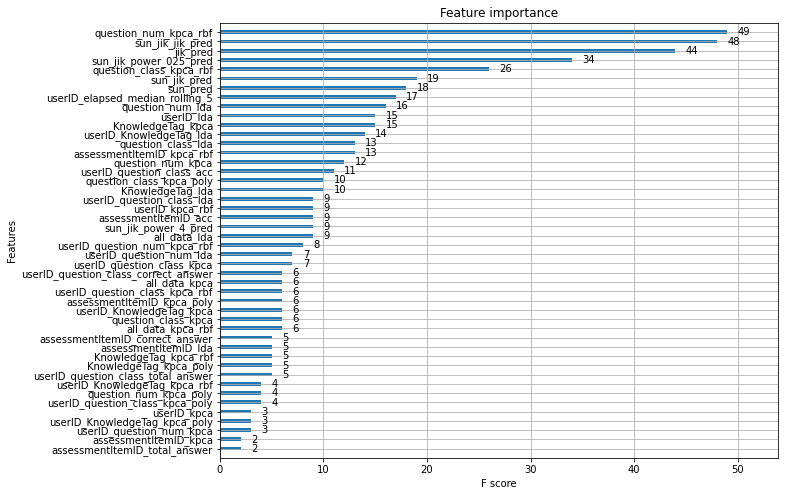

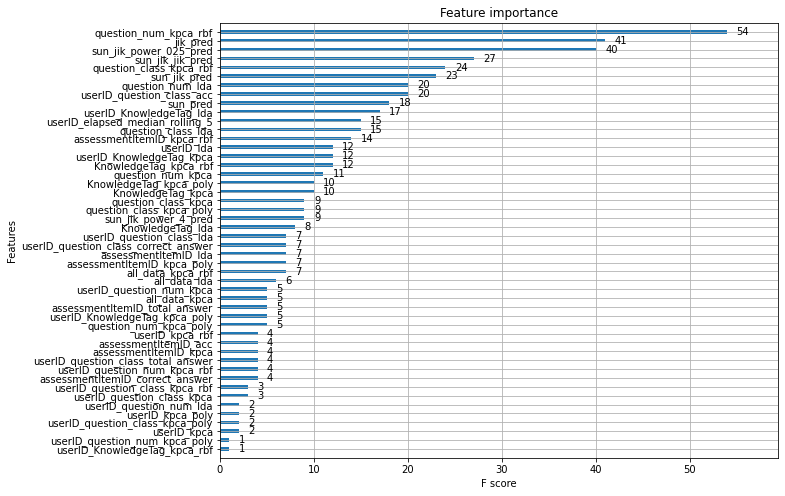

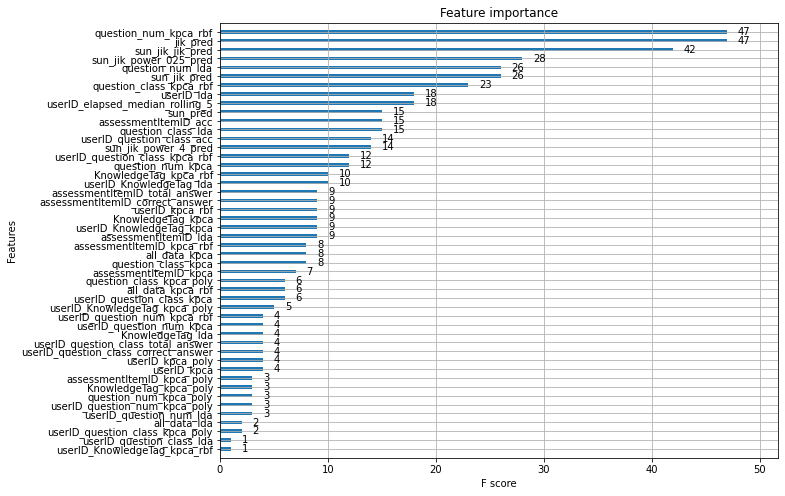

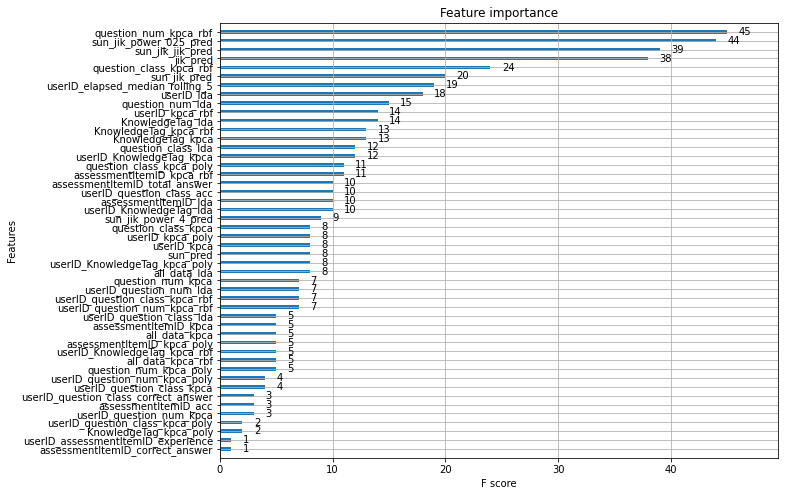

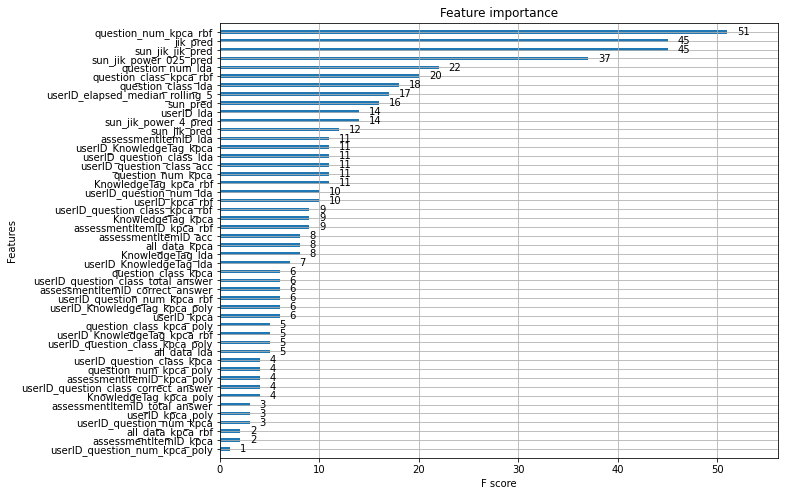

In [30]:
import xgboost as xgb

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

params = set_params()

auc_score = 0

final_preds = []

print("@"*50)
print("start")
print("@"*50)

for fold, (train_index, test_index) in enumerate(skf.split(train, train["answerCode"])):

    temp_train = train.iloc[train_index,:]
    temp_valid = train.iloc[test_index,:]

    # X, y 값 분리
    y_train = temp_train["answerCode"]
    train_df = temp_train.drop(["answerCode"], axis=1)

    y_test = temp_valid["answerCode"]
    test_df = temp_valid.drop(["answerCode"], axis=1)

    D_train = xgb.DMatrix(train_df, label=y_train)
    D_test = xgb.DMatrix(test_df, label=y_test)
    
    y_final = test["answerCode"]
    final = test.drop(["answerCode"], axis=1)
    D_final = xgb.DMatrix(final, label=y_final)

    model = xgb.train(params, D_train, num_boost_round=100)

    preds = model.predict(D_test)

    acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_test, preds)

    print(f'VALID AUC : {auc} ACC : {acc}\n')
    
    final_preds.append(model.predict(D_final))
    
    fig,ax = plt.subplots(figsize=(10,8))
    plot_importance(model, ax=ax, max_num_features = 50, height=.4)

    auc_score += auc

print(auc_score / 5)

In [31]:
result = pd.DataFrame(np.array(final_preds).mean(axis=0)).reset_index().rename(columns = {0:"prediction", "index":"id"})
result.to_csv("stacking.csv", index=False)

<AxesSubplot:>

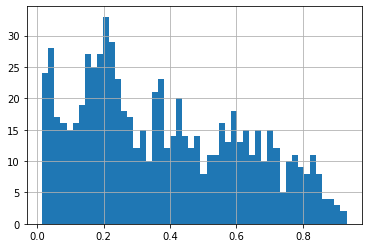

In [32]:
result["prediction"].hist(bins=50)